# Voting

In [177]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [178]:
from Preprocessing import *

In [243]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'mediana')
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,31.0,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,31.0,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


## Entrenamiento

In [244]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

In [246]:
params_arbol = {'max_depth': np.arange(1, 50),
                'min_samples_leaf': np.arange(1, 50),
                'criterion': ['gini', 'entropy']
               }

arbol = DecisionTreeClassifier(random_state=117)

rgscv_arbol = RandomizedSearchCV(arbol, params_arbol, n_iter=60, scoring='roc_auc', cv=5, 
                                 return_train_score=True).fit(X_train, y_train)

print(f"ARBOL -> Best score: {rgscv_arbol.best_score_}")
print(f"ARBOL -> Best params {rgscv_arbol.best_params_}")

ARBOL -> Best score: 0.8457484482569069
ARBOL -> Best params {'min_samples_leaf': 18, 'max_depth': 38, 'criterion': 'gini'}


In [247]:
arbol  = DecisionTreeClassifier(max_depth=rgscv_arbol.best_params_['max_depth'],
                                min_samples_leaf=rgscv_arbol.best_params_['min_samples_leaf'],
                                criterion=rgscv_arbol.best_params_['criterion'],
                                random_state=117)

In [248]:
params_forest = {'n_estimators': np.arange(1, 50),
                 'max_samples': np.arange(1, 50),
                 'min_samples_split': np.arange(1, 50),
                 'max_features': np.arange(1, 50),
                 'criterion': ['gini', 'entropy']
                }

forest = RandomForestClassifier(random_state=117)

rgscv_forest = RandomizedSearchCV(forest, params_forest, n_iter=60, scoring='roc_auc', cv=5, 
                                 return_train_score=True).fit(X_train, y_train)

print(f"FOREST -> Best score: {rgscv_forest.best_score_}")
print(f"FOREST -> Best params {rgscv_forest.best_params_}")

FOREST -> Best score: 0.8450429330144965
FOREST -> Best params {'n_estimators': 19, 'min_samples_split': 6, 'max_samples': 49, 'max_features': 14, 'criterion': 'entropy'}


In [249]:
forest = RandomForestClassifier(n_estimators=rgscv_forest.best_params_['n_estimators'],
                                min_samples_split=rgscv_forest.best_params_['min_samples_split'],
                                max_samples=rgscv_forest.best_params_['max_samples'],
                                max_features=rgscv_forest.best_params_['max_features'],
                                criterion=rgscv_forest.best_params_['criterion'],
                                random_state=117)

In [250]:
params_ada = {'n_estimators': np.arange(25, 100),
              'learning_rate': [0.1, 0.2, 0.4, 0.7],
              'algorithm': ['SAMME', 'SAMME.R']
             }

ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(
    max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"), random_state=117)

rgscv_ada = RandomizedSearchCV(ada, params_ada, n_iter=60, scoring='roc_auc', cv=5, 
                                 return_train_score=True).fit(X_train, y_train)

print(f"ADA -> Best score: {rgscv_ada.best_score_}")
print(f"ADA -> Best params {rgscv_ada.best_params_}")

ADA -> Best score: 0.8508936886019874
ADA -> Best params {'n_estimators': 90, 'learning_rate': 0.1, 'algorithm': 'SAMME'}


In [251]:
ada = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117,
    n_estimators = rgscv_ada.best_params_['n_estimators'],
    learning_rate = rgscv_ada.best_params_['learning_rate'],
    algorithm = rgscv_ada.best_params_['algorithm'])

In [252]:
model_voting = VotingClassifier(
        estimators=[('arbol', arbol), ('forest', forest), ('ada', ada)], voting='soft'
    )

In [253]:
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=38, min_samples_leaf=18, random_state=117)

In [254]:
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=14, max_samples=49,
                       min_samples_split=6, n_estimators=19, random_state=117)

In [255]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3,
                                                         min_samples_leaf=10,
                                                         random_state=117),
                   learning_rate=0.1, n_estimators=90, random_state=117)

In [256]:
model_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('arbol',
                              DecisionTreeClassifier(max_depth=38,
                                                     min_samples_leaf=18,
                                                     random_state=117)),
                             ('forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features=14,
                                                     max_samples=49,
                                                     min_samples_split=6,
                                                     n_estimators=19,
                                                     random_state=117)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                

In [257]:
prob_pred_voting = model_voting.predict(X_test)

In [258]:
accuracy_score(prob_pred_voting,y_test)

0.8159203980099502

In [259]:
model_voting_hard = VotingClassifier(
        estimators=[('arbol', arbol), ('forest', forest), ('ada', ada)], voting='hard'
    )
model_voting_hard.fit(X_train, y_train)
prob_pred_voting_hard = model_voting_hard.predict(X_test)
accuracy_score(prob_pred_voting_hard,y_test)

0.8258706467661692

## K-Fold Stratified Validation

In [260]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = StratifiedKFold(n_splits=5)

for voting_var in ['hard', 'soft']:
    model_voting = VotingClassifier(
        estimators=[('arbol', arbol), ('forest', forest), ('ada', ada)], voting=voting_var
    )
    test_rocs = []
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
        arbol.fit(X.iloc[train_index], y.iloc[train_index])
        forest.fit(X.iloc[train_index], y.iloc[train_index])
        ada.fit(X.iloc[train_index], y.iloc[train_index])
        model_voting.fit(X.iloc[train_index], y.iloc[train_index])
        test_roc = roc_auc_score(y.iloc[test_index], model_voting.predict(X.iloc[test_index]))
        print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
        test_rocs.append(test_roc)
    print(f"Mean test AUC ROC for {voting_var} Voting is: {np.mean(test_rocs):.4f}\n\n")

Fold 0: AUC ROC score is 0.7539
Fold 1: AUC ROC score is 0.7547
Fold 2: AUC ROC score is 0.8234
Fold 3: AUC ROC score is 0.7824
Fold 4: AUC ROC score is 0.8060
Mean test AUC ROC for hard Voting is: 0.7841


Fold 0: AUC ROC score is 0.7408
Fold 1: AUC ROC score is 0.7679
Fold 2: AUC ROC score is 0.8020
Fold 3: AUC ROC score is 0.8108
Fold 4: AUC ROC score is 0.7818
Mean test AUC ROC for soft Voting is: 0.7807




### AUC ROC

In [261]:
roc = roc_auc_score(y_test, prob_pred_voting_hard)
print(f"{roc:.4f}")

0.7889


### Accuracy

In [262]:
acc = accuracy_score(y_test, prob_pred_voting_hard)
print(f"{acc:.4f}")

0.8259


### Precision

In [263]:
precision = precision_score(y_test, prob_pred_voting_hard)
print(f"{precision:.4f}")

0.8421


### Recall

In [264]:
recall = recall_score(y_test, prob_pred_voting_hard, pos_label=0)
print(f"{recall:.4f}")

0.9291


### F1-Score

In [265]:
f1 = f1_score(y_test, prob_pred_voting_hard)
print(f"{f1:.4f}")

0.7328


### Matriz de confusión

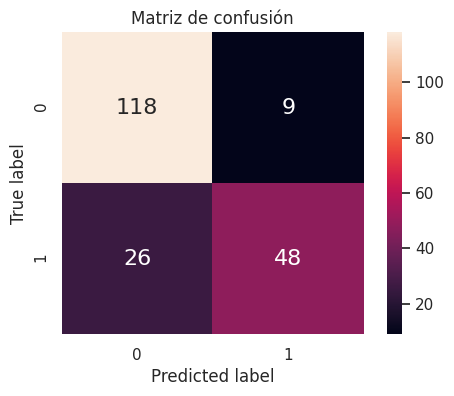

In [266]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusión")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, prob_pred_voting_hard)

## Test Holdout

In [267]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
holdout.head(5)

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


In [268]:
df_h = prepod_tp1_un_df(holdout)
df_h = replace_nulls_edad(df_h, 'mediana')
df_h = encodear_atributos_categoricos(df_h)
df_h = df_h.drop(['volveria'], axis=1)
df_h.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,650,0,1,26.0,0,0,1,0,0,1,0
1,0,0,1,234,0,1,8.0,4,2,4,0,0,1,6
2,0,1,0,31,1,0,43.0,0,0,3,0,1,0,0
3,0,1,1,552,1,0,30.0,0,0,3,0,0,1,0
4,0,0,1,411,1,0,32.0,0,0,1,0,0,1,0


In [269]:
y_pred = model_voting_hard.predict(df_h)
y_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1])

In [270]:
(y_pred.shape, df_h.shape)

((90,), (90, 14))

In [271]:
serie_predicha = pd.Series(y_pred, name='volveria') 
serie_predicha = serie_predicha.to_frame()
serie_predicha.head(15)

,volveria
0,0
1,0
2,1
3,1
4,0
5,0
6,0
7,0
8,1
9,0


In [272]:
df_predicho = holdout.join(serie_predicha, how='inner')
cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,1
3,552,1
4,411,0


In [273]:
df_resultado.shape

(90, 2)

In [274]:
df_resultado.to_csv('prediccion/voting_resultado_final.csv')